# Imports

In [27]:
from DS_project_utils.load_data import *
from DS_project_utils.feature_selection import *
from DS_project_utils.model import *
from DS_project_utils.feature_extraction import *

import warnings
warnings.filterwarnings("ignore")

# The expiriment process

In [2]:
# this function executes the method with the defined parameters and return the score of the method
def method(path,dataset, target_feature,extraction,extraction_method, n, selection, corr_method, corr_per):
    # load and preprocess data
    df = load_data(path,dataset)
    df = pd.get_dummies(df, drop_first=True)
    numeric_columns, very_numerical, categorical_columns, df = preprocess_data(df)
    # feature extraction
    if extraction:
        df = feature_extraction(df, target_feature,extraction_method,n, selection)
    # feature selection
    if selection:
        corr_selected_featurs, corr_droped_featurs = correlation_selection(df,very_numerical,target_feature,corr_method,corr_per)
        chi_selected_featurs, chi_droped_featurs = chi_squared_selection(df,dataset,categorical_columns,target_feature,corr_per)
        df = df.drop(columns=corr_droped_featurs)
        df = df.drop(columns=chi_droped_featurs)
    # split
    X_train, X_test, y_train, y_test = split(df, target_feature)
    # predict
    model, prediction = predict(X_train, X_test, y_train, dataset)
    # evaluate
    model_score = evaluate(dataset, X_test, y_test, prediction)
    if dataset == "MobilePrice":
        exp_score = explainability_score_multiclass(model, X_test)
    else:
        exp_score = explainability_score(model, X_test)
    return model_score,exp_score

In [3]:
performance_measure = {'houses':'adjusted_R_squared',"breast_cancer": "accuracy","leukemia": "accuracy",
                       "MobilePrice": "accuracy","mushrooms": "accuracy"}
# This function manages the analysis for all the different methods
def compare_diffrent_methods(path,dataset,target_feature):
    evaluation_table = []
    evaluation_table.append(method(path,dataset, target_feature,False,None,0,False, None, 1))
    evaluation_table.append(method(path,dataset, target_feature,False,None,0,True, "spearman", 0.7))
    evaluation_table.append(method(path,dataset, target_feature,False,None,0,True, "spearman", 0.5))
    evaluation_table.append(method(path,dataset, target_feature,False,None,0,True, "spearman",0.2))
    evaluation_table.append(method(path,dataset, target_feature,True,"PCA",5,True, "spearman", 0.2))
    evaluation_table.append(method(path,dataset, target_feature,True,"ICA",5,True, "spearman", 0.2))
    evaluation_table.append(method(path,dataset, target_feature,True,"both",5,True, "spearman", 0.2))
    df = pd.DataFrame(evaluation_table,columns =[performance_measure[dataset],'explainability_score'],
                      index = ["baseline","70% selection","50% selection",
                               "20% selection","combination PCA", "combination ICA", "final method"])
    return df
# This function manages the analysis for all the different extraction methods
def compare_extraction_methods(path,dataset,target_feature):
    evaluation_table = []
    evaluation_table.append(method(path,dataset, target_feature,True,"PCA",3,False, None, 1)[0])
    evaluation_table.append(method(path,dataset, target_feature,True,"PCA",5,False, None, 1)[0])
    evaluation_table.append(method(path,dataset, target_feature,True,"PCA",10,False, None, 1)[0])
    evaluation_table.append(method(path,dataset, target_feature,True,"ICA",3,False, None, 1)[0])
    evaluation_table.append(method(path,dataset, target_feature,True,"ICA",5,False, None, 1)[0])
    evaluation_table.append(method(path,dataset, target_feature,True,"ICA",10,False, None, 1)[0])
    df = pd.DataFrame(evaluation_table,columns =[performance_measure[dataset]],
                      index = ["PCA n = 3", "PCA n = 5", "PCA n = 10", "ICA n = 3", "ICA n = 5", "ICA n = 10"])
    return df

# houses

###### https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

In [28]:
houses = load_data("Data/houses.csv", "houses")

In [5]:
houses.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [6]:
# evaluate different extraction methods
extraction_table = compare_extraction_methods("Data/houses.csv","houses","SalePrice")
extraction_table

,adjusted_R_squared
PCA n = 3,0.699460
PCA n = 5,0.708607
PCA n = 10,0.743829
ICA n = 3,0.699460
ICA n = 5,0.708607
ICA n = 10,0.743829


<Figure size 480x480 with 0 Axes>

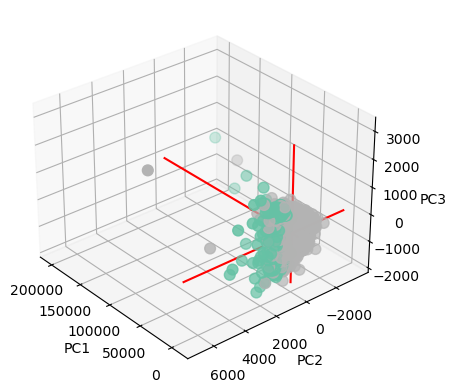

In [7]:
# visualize PCA feature extraction with n = 3
feature_extraction_3D_visual(houses,"houses","SalePrice")

In [8]:
# evaluate different selection methods
evaluation_table = compare_diffrent_methods("Data/houses.csv","houses","SalePrice")
evaluation_table

,adjusted_R_squared,explainability_score
baseline,0.108695,0.277790
70% selection,0.763506,0.265592
50% selection,0.819273,0.328873
20% selection,0.850381,0.459419
combination PCA,0.850298,0.401581
combination ICA,0.850298,0.398081
final method,0.847353,0.398081


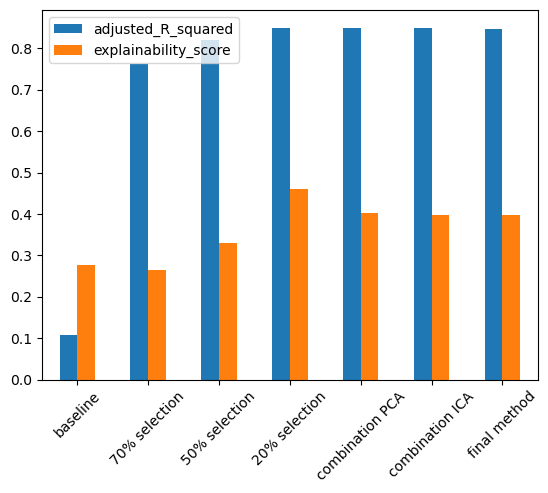

In [9]:
ax = evaluation_table.plot.bar(rot=45)

# breast cancer

###### https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data

In [29]:
breast_cancer = load_data("Data/breast_cancer.csv", "breast_cancer")

In [11]:
breast_cancer.describe()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,4.240000e+02,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,...,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000
mean,3.718060e+07,0.500000,14.761123,19.836981,96.422948,717.712028,0.097324,0.112018,0.103596,0.056364,...,17.207948,26.417948,113.838113,987.178302,0.134770,0.277543,0.308796,0.127381,0.296354,0.085711
std,1.434875e+08,0.500591,3.755908,4.325662,25.914546,380.492847,0.013807,0.056275,0.085258,0.041510,...,5.167801,6.215121,35.923787,617.958700,0.023553,0.168052,0.218672,0.068917,0.065802,0.019175
min,8.670000e+03,0.000000,6.981000,9.710000,43.790000,143.500000,0.064290,0.023440,0.000000,0.000000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.672188e+05,0.000000,12.022500,16.840000,77.602500,444.575000,0.086842,0.067925,0.033327,0.022158,...,13.300000,21.885000,86.512500,544.975000,0.119275,0.154975,0.135675,0.068683,0.255050,0.072468
50%,9.053450e+05,0.500000,14.000000,19.565000,91.040000,602.650000,0.097175,0.102800,0.086575,0.048635,...,16.045000,26.180000,106.100000,786.300000,0.134800,0.234700,0.286350,0.121800,0.284650,0.081660
75%,8.910788e+06,1.000000,17.312500,22.292500,114.200000,931.450000,0.106525,0.143750,0.152550,0.086260,...,20.585000,30.730000,137.950000,1302.500000,0.149725,0.372750,0.429650,0.182000,0.321650,0.094715
max,9.113205e+08,1.000000,28.110000,39.280000,188.500000,2501.000000,0.144700,0.345400,0.426800,0.201200,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [12]:
# evaluate different extraction methods
extraction_table = compare_extraction_methods("Data/breast_cancer.csv", "breast_cancer","diagnosis")
extraction_table

,accuracy
PCA n = 3,0.433962
PCA n = 5,0.433962
PCA n = 10,0.433962
ICA n = 3,0.801887
ICA n = 5,0.896226
ICA n = 10,0.896226


<Figure size 480x480 with 0 Axes>

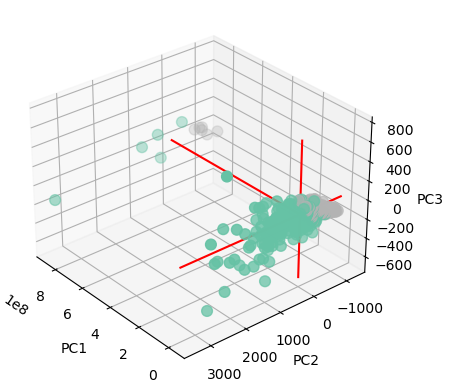

In [13]:
# visualize PCA feature extraction with n = 3
feature_extraction_3D_visual(breast_cancer, "breast_cancer","diagnosis")

In [14]:
# evaluate different selection methods
evaluation_table = compare_diffrent_methods("Data/breast_cancer.csv", "breast_cancer","diagnosis")
evaluation_table

,accuracy,explainability_score
baseline,0.528302,1.000000e+00
70% selection,0.915094,8.534123e-01
50% selection,0.915094,9.191032e-01
20% selection,0.877358,1.000000e+00
combination PCA,0.433962,8.445018e-08
combination ICA,0.877358,9.961433e-01
final method,0.905660,9.933481e-01


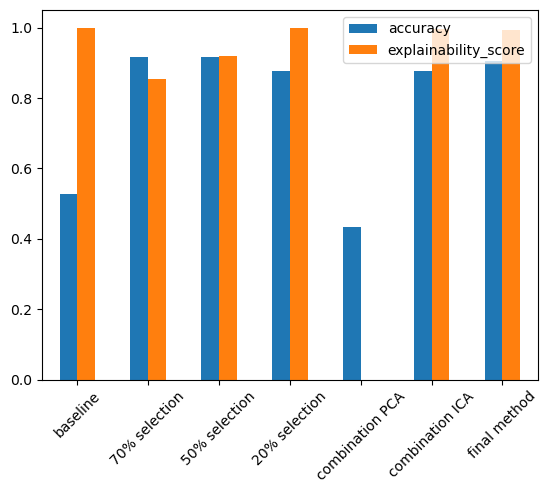

In [15]:
ax = evaluation_table.plot.bar(rot=45)

# mushroom

###### https://www.kaggle.com/datasets/uciml/mushroom-classification

In [30]:
mushrooms = load_data("Data/mushrooms.csv", "mushrooms")

In [31]:
# evaluate different extraction methods
extraction_table = compare_extraction_methods("Data/mushrooms.csv", "mushrooms","class")
extraction_table

,accuracy
PCA n = 3,0.876416
PCA n = 5,0.880355
PCA n = 10,0.937962
ICA n = 3,0.892664
ICA n = 5,0.892664
ICA n = 10,0.926637


<Figure size 480x480 with 0 Axes>

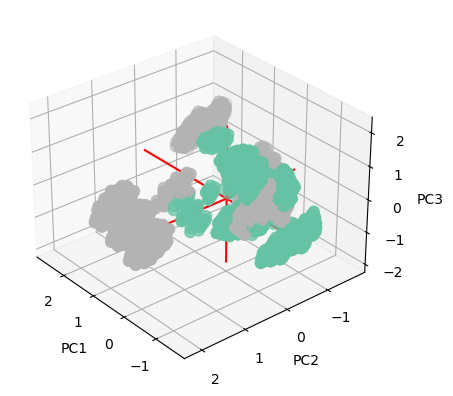

In [18]:
# visualize PCA feature extraction with n = 3
feature_extraction_3D_visual(mushrooms, "mushrooms","class")

In [19]:
# evaluate different selection methods
evaluation_table = compare_diffrent_methods("Data/mushrooms.csv", "mushrooms","class")
evaluation_table

,accuracy,explainability_score
baseline,1.000000,0.441524
70% selection,0.999015,0.504132
50% selection,0.997046,0.534267
20% selection,0.975874,0.632384
combination PCA,0.972427,0.479967
combination ICA,0.975874,0.632007
final method,0.975874,0.631632


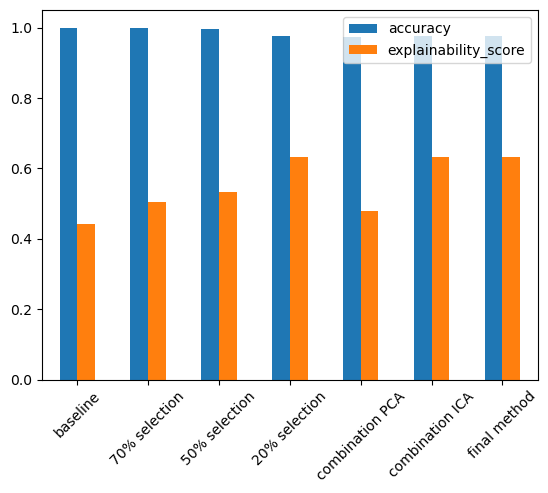

In [20]:
ax = evaluation_table.plot.bar(rot=45)

# Mobile Price

###### https://www.kaggle.com/datasets/jai8004/mobile-price-prediction

In [33]:
MobilePrice = load_data("Data/MobilePrice.csv", "MobilePrice")

In [22]:
MobilePrice.describe()

,battery_power,clock_speed,front_camera_mpixels,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,price_range
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,1.522250,4.309500,32.046500,0.501750,140.249000,4.520500,9.916500,645.108000,1251.515500,2124.213000,12.306500,5.767000,11.011000,1.500000
std,439.418206,0.816004,4.341444,18.145715,0.288416,35.399655,2.287837,6.064315,443.780811,432.199447,1084.732044,4.213245,4.356398,5.463955,1.118314
min,501.000000,0.500000,0.000000,2.000000,0.100000,80.000000,1.000000,0.000000,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000
25%,851.750000,0.700000,1.000000,16.000000,0.200000,109.000000,3.000000,5.000000,282.750000,874.750000,1207.500000,9.000000,2.000000,6.000000,0.750000
50%,1226.000000,1.500000,3.000000,32.000000,0.500000,141.000000,4.000000,10.000000,564.000000,1247.000000,2146.500000,12.000000,5.000000,11.000000,1.500000
75%,1615.250000,2.200000,7.000000,48.000000,0.800000,170.000000,7.000000,15.000000,947.250000,1633.000000,3064.500000,16.000000,9.000000,16.000000,2.250000
max,1998.000000,3.000000,19.000000,64.000000,1.000000,200.000000,8.000000,20.000000,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,3.000000


In [32]:
# evaluate different extraction methods
extraction_table = compare_extraction_methods("Data/MobilePrice.csv", "MobilePrice","price_range")
extraction_table

,accuracy
PCA n = 3,0.962
PCA n = 5,0.676
PCA n = 10,0.624
ICA n = 3,0.708
ICA n = 5,0.734
ICA n = 10,0.728


<Figure size 480x480 with 0 Axes>

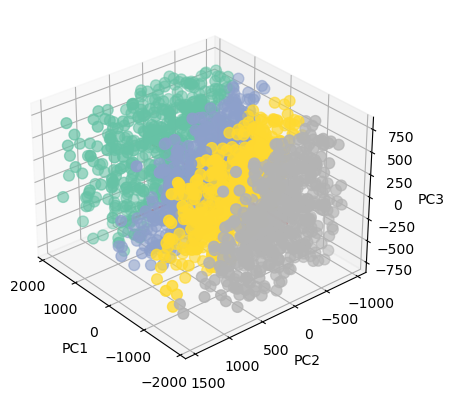

In [24]:
# visualize PCA feature extraction with n = 3
feature_extraction_3D_visual(MobilePrice, "MobilePrice","price_range")

In [25]:
# evaluate different selection methods
evaluation_table = compare_diffrent_methods("Data/MobilePrice.csv", "MobilePrice","price_range")
evaluation_table

,accuracy,explainability_score
baseline,0.616,0.959062
70% selection,0.560,0.923734
50% selection,0.604,0.965015
20% selection,0.628,1.000000
combination PCA,0.982,0.113630
combination ICA,0.742,0.996854
final method,0.750,0.992883


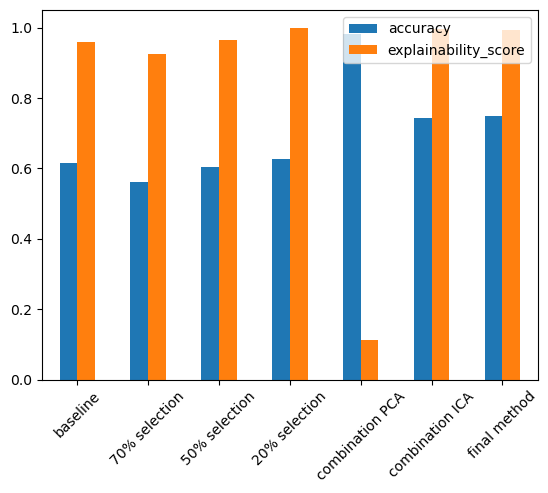

In [26]:
ax = evaluation_table.plot.bar(rot=45)